In [1]:
%pylab inline
from matplotlib import pyplot as plt
import networkx as nx
from networkx import bipartite
from networkx import NetworkXNoPath
import random
import scipy.stats as spstats
import tqdm
from netdelib.topologies.topologies import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_layer_graph(stage_pods):
    '''
    stage_pods: [stage][pod][node]'''
    G = nx.DiGraph()
    all_nodes = [
        elt
        for pod in stage_pods[0]
            for elt in pod]
    for stage, pods in enumerate(stage_pods):
        for i, pod in enumerate(pods):
            for s in pod:
                # Create label for source node
                s_label = '{}-{}'.format(stage, s)
                # Create label for end-stage sink node
                f_label = 'f-{}'.format(s)
                G.add_edge(s_label, f_label, weight=0)
                for t in pod:
                    # Create labels for target nodes
                    t_label = '{}-{}'.format(stage + 1, t)
                    # Connections between nodes in same pod
                    G.add_edge(s_label, t_label, weight=1)
    return G

In [39]:
def test_residue(M=5, D=3, all_N=range(20,80), lowest=2, link_adjacent=False):
    result = {
        'harmonic': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        # Generate graph from list of groups at each stage
        # Stage 0 groups adjacent nodes, treating all as the same modulus class
        if link_adjacent:
            lower = 0
            upper = D
        else:
            lower = 1
            upper = D + 1
        stage_groups = [
            get_long_path_stage_groups(N, M, i, lowest=lowest)
            for i in range(lower, upper)]
        G_residue = get_layer_graph(stage_groups)
        residue_lengths = []
        for s in range(N):
            for t in range(N):
                if s == t:
                    continue
                # Find path length from first stage to end-stage
                s_id = '0-{}'.format(s)
                t_id = 'f-{}'.format(t)
                try:
                    length = nx.shortest_path_length(
                        G_residue, s_id, t_id, weight='weight')
                    residue_lengths.append(length)
                    kcon_total += 1
                except NetworkXNoPath:
                    residue_lengths.append(float('inf'))
        harmonic_total += spstats.hmean(residue_lengths)
        result['harmonic'].append(harmonic_total)
        result['kcon'].append(kcon_total / N / (N - 1))
    return result

In [29]:
def test_random(M=5, D=3, all_N=range(20,80), num_iter=10):
    result = {
        'harmonic': [],
        'kcon': []
    }
    # Iterate through network sizes
    for N in tqdm.tqdm(all_N):
        # Initialize totals
        harmonic_total = 0
        kcon_total = 0
        # Run multiple trials
        for m in range(num_iter):
            # Generate graph from list of groups at each stage
            stage_groups = [
                get_random_stage_groups(N, M, i)
                for i in range(D)]
            G_random = get_layer_graph(stage_groups)
            random_lengths = []
            for s in range(N):
                for t in range(N):
                    if s == t:
                        continue
                    # Find path length from first stage to end-stage
                    s_id = '0-{}'.format(s)
                    t_id = 'f-{}'.format(t)
                    try:
                        length = nx.shortest_path_length(
                            G_random, s_id, t_id, weight='weight')
                        random_lengths.append(length)
                        kcon_total += 1
                    except NetworkXNoPath:
                        random_lengths.append(float('inf'))
            harmonic_total += spstats.hmean(random_lengths)
        result['harmonic'].append(harmonic_total / num_iter)
        result['kcon'].append(kcon_total / N / (N - 1) / num_iter)
    return result

In [21]:
M=6
D=3
lowest=2
step=5
all_N = range(7, 100, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest)

100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


In [22]:
random_result = test_random(M=M, D=D, all_N=all_N)

100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


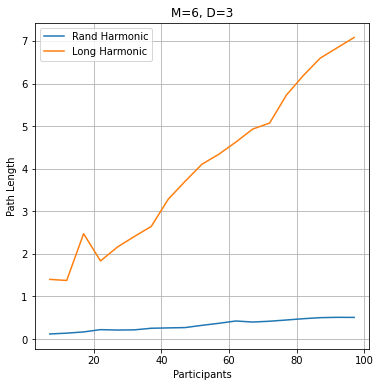

In [23]:
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D))
plt.plot(all_N, random_result['harmonic'], label="Rand Harmonic")
plt.plot(all_N, residue_result['harmonic'], label="Long Harmonic")
plt.legend()
plt.xlabel("Participants")
plt.ylabel("Path Length")
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)

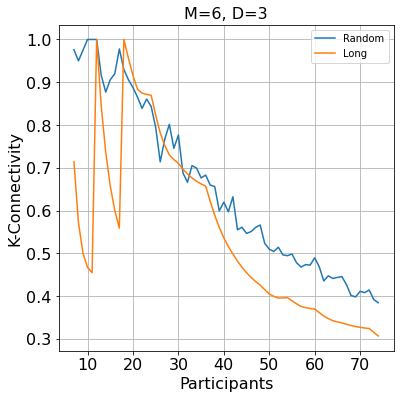

In [15]:
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)

100%|██████████| 18/18 [00:28<00:00,  1.61s/it]


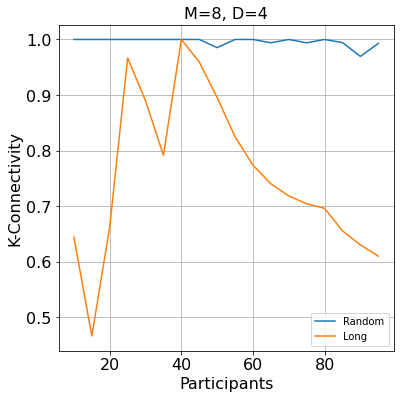

In [35]:
M=8
D=4
lowest=2
step=5
all_N = range(10, 100, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest)
random_result = test_random(M=M, D=D, all_N=all_N, num_iter=1)
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)

100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


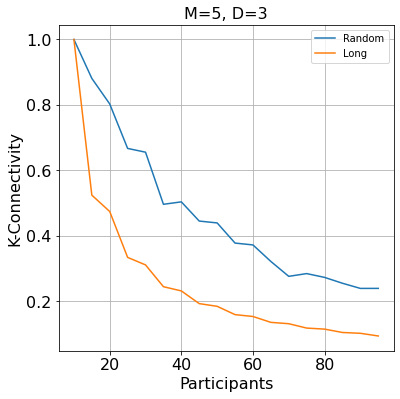

In [42]:
M=5
D=3
lowest=2
step=5
all_N = range(10, 100, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)
random_result = test_random(M=M, D=D, all_N=all_N, num_iter=1)
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.savefig('NetDelib-2019-02-22.png', dpi=300)

100%|██████████| 91/91 [01:28<00:00,  1.03it/s]


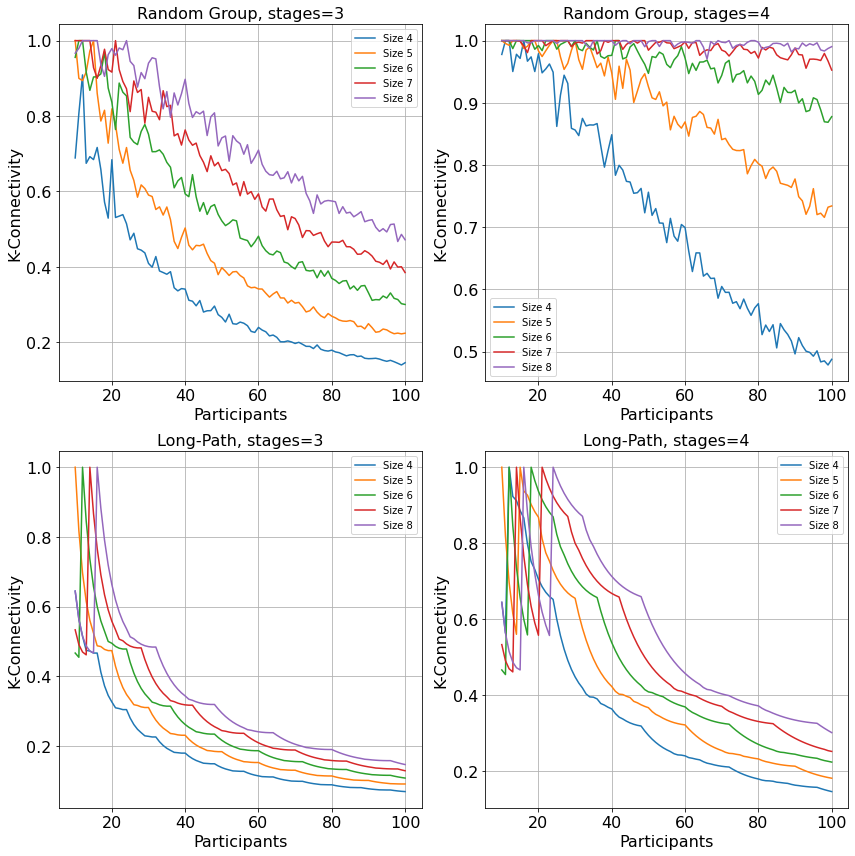

In [54]:
lowest=2
step=1
all_N = range(10, 101, step)
plt.figure(figsize=(12,12))
cell = 0
for D in range(3,5):
    cell += 1
    plt.subplot(2,2,cell)
    for M in range(4,9):
        random_result = test_random(M=M, D=D, all_N=all_N, num_iter=4)
        plt.title("Random Group, stages={}".format(D), fontsize=16)
        plt.plot(all_N, random_result['kcon'], label="Size {}".format(M))
    plt.xlabel("Participants", fontsize=16)
    plt.ylabel("K-Connectivity", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid()
for D in range(3,5):
    cell += 1
    plt.subplot(2,2,cell)
    for M in range(4,9):
        residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)
        plt.plot(all_N, residue_result['kcon'], label="Size {}".format(M))
    plt.title("Long-Path, stages={}".format(D), fontsize=16)
    plt.xlabel("Participants", fontsize=16)
    plt.ylabel("K-Connectivity", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend()
plt.savefig('NetDelib-2021-06-27.png', dpi=300)        
plt.tight_layout()        
        

100%|██████████| 29/29 [04:33<00:00,  9.44s/it]


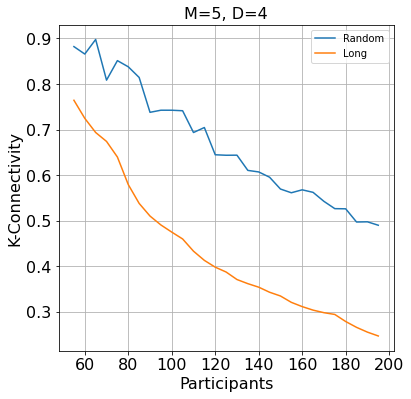

In [55]:
M=5
D=4
lowest=5
step=5
all_N = range(55, 200, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)
random_result = test_random(M=M, D=D, all_N=all_N, num_iter=1)
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

100%|██████████| 29/29 [01:38<00:00,  3.39s/it]


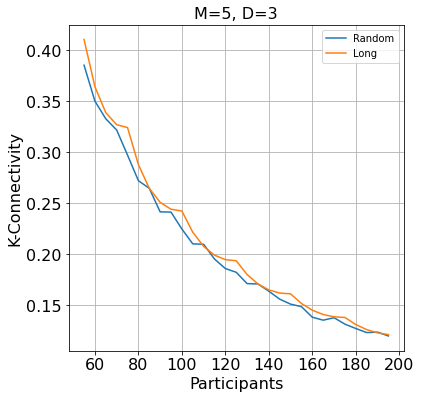

In [56]:
M=5
D=3
lowest=5
step=5
all_N = range(55, 200, step)
residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)
random_result = test_random(M=M, D=D, all_N=all_N, num_iter=1)
plt.figure(figsize=(6,6))
plt.title("M={}, D={}".format(M, D), fontsize=16)
plt.plot(all_N, random_result['kcon'], label="Random")
plt.plot(all_N, residue_result['kcon'], label="Long")
plt.legend()
plt.xlabel("Participants", fontsize=16)
plt.ylabel("K-Connectivity", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

100%|██████████| 191/191 [31:50<00:00, 10.00s/it]


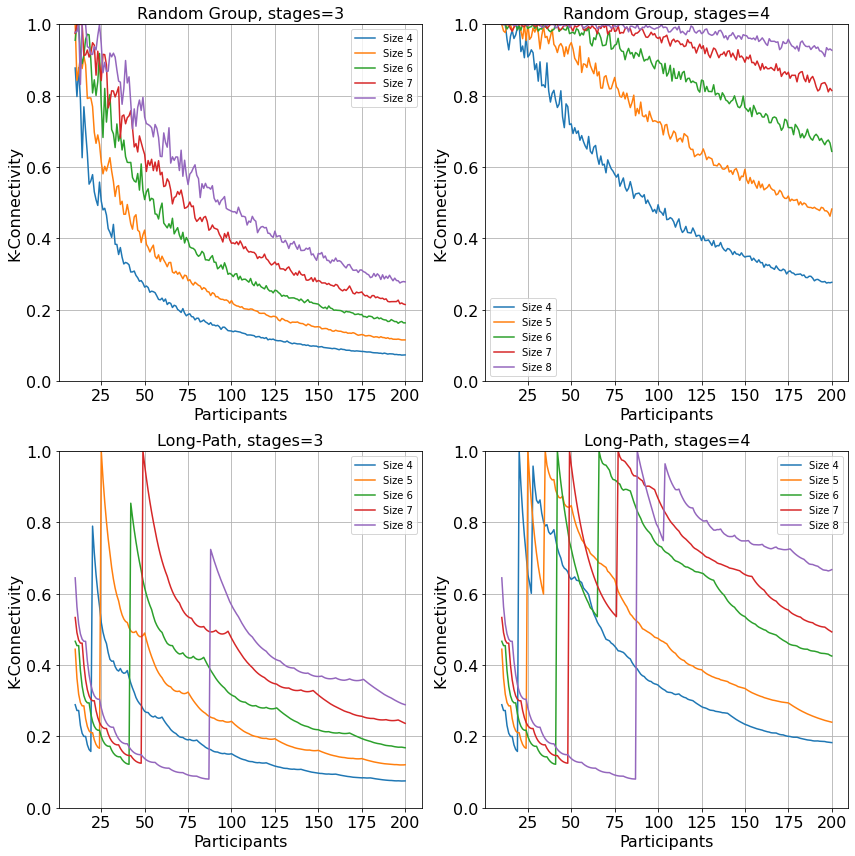

In [58]:
primes = [2, 3, 5, 7, 11]
step=1
all_N = range(10, 201, step)
plt.figure(figsize=(12,12))
cell = 0
for D in range(3,5):
    cell += 1
    plt.subplot(2,2,cell)
    for M in range(4,9):
        random_result = test_random(M=M, D=D, all_N=all_N, num_iter=4)
        plt.title("Random Group, stages={}".format(D), fontsize=16)
        plt.plot(all_N, random_result['kcon'], label="Size {}".format(M))
    plt.xlabel("Participants", fontsize=16)
    plt.ylabel("K-Connectivity", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid()
    plt.ylim([0, 1])
for D in range(3,5):
    cell += 1
    plt.subplot(2,2,cell)
    for M in range(4,9):
        lowest = [x for x in primes if x >= M][0]
        residue_result = test_residue(M=M, D=D, all_N=all_N, lowest=lowest, link_adjacent=True)
        plt.plot(all_N, residue_result['kcon'], label="Size {}".format(M))
    plt.title("Long-Path, stages={}".format(D), fontsize=16)
    plt.xlabel("Participants", fontsize=16)
    plt.ylabel("K-Connectivity", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend()
    plt.ylim([0, 1])
plt.savefig('NetDelib-2021-06-29-low_overlap.png', dpi=300)        
plt.tight_layout()        
        